<table width="50%"><tr>
<td> <img src="../../img/dipy_logo.png" align="left" alt="Drawing" style="width: 155px;"/> </td>
<td> <img src="../../img/gsoc_logo.png" align="right" alt="Drawing" style="width: 220px;"/> </td>
</tr></table>

**Student**\
David Romero-Bascones\
**Mentors**\
Bramsh Qamar Chandio\
Shreyas Fadnavis\
Jong Sung Park

## **Halfway Streamline Linear Registration: experiment**

Registration accuracy comparison between Streamline Linear Registration (SLR) and Halfway Streamline Linear Registration (HSLR)

Methods compared:
- SLR
- SLR inverted
- SLR progressive (in two steps)
- HSLR analytical
- HSLR progressive
- HSLR symmetric 

### **Libraries and helper functions**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

from dipy.align.bundlemin import distance_matrix_mdf
from dipy.io.streamline import load_trk
from dipy.align.streamlinear import (StreamlineLinearRegistration,
                                     compose_matrix44, decompose_matrix44,
                                     remove_clusters_by_size)
from dipy.tracking.streamline import set_number_of_points, transform_streamlines, select_random_set_of_streamlines
from dipy.segment.clustering import qbx_and_merge

In [2]:
def bundle_distance_min(D):
    rows, cols = D.shape
    return 0.25 * (np.sum(np.min(D, axis=0)) / float(cols) +
                   np.sum(np.min(D, axis=1)) / float(rows)) ** 2

### **Load all bundles and preprocess them**

In [3]:
# Data configuration
in_dir = '/home/david/Dropbox (MGEP)/projects/GSoC-2021/data/PPMI_data'
bundle_name = 'AF_L'
subjects = pd.read_csv(f'{in_dir}/subjects.csv', delimiter='\t', dtype='object')['participant']

n_stream = 1000
n_point = 20

bundles = []
for sub in subjects:
    # Load bundle
    file = f'{in_dir}/{sub}/org_bundles/streamlines_moved_{bundle_name}__labels__recognized_orig.trk'
    bundle_obj = load_trk(file, reference='same', bbox_valid_check=False)

    bundle = set_number_of_points(bundle_obj.streamlines, n_point)
    bundle = select_random_set_of_streamlines(bundle, n_stream)

    bundles.append(bundle)

### **Run experiment**

In [4]:
x0 = 'affine'
qbx_th = 5
N = 300  # Number of pairs

np.random.seed(0)  # for reproducibility

d_0 = np.empty(N)
d_slr = np.empty(N)
d_slr_inv = np.empty(N)
d_hslr_anal = np.empty(N)
d_hslr_prog = np.empty(N)
d_hslr_sym = np.empty(N)
d_slr_prog = np.empty(N)

# Get all bundle pair combinations
pairs = list(combinations(np.arange(len(subjects)),2))
index = np.random.permutation(len(pairs))

for i in range(N):
   
    bundle1 = bundles[pairs[index[i]][0]]
    bundle2 = bundles[pairs[index[i]][1]]

    # Compute distance in native space
    d_0[i] = bundle_distance_min(distance_matrix_mdf(bundle1, bundle2))

    # Get centroids of both bundles
    cluster1 = qbx_and_merge(bundle1, thresholds=[qbx_th])
    centroids1 = remove_clusters_by_size(cluster1, 1)

    cluster2 = qbx_and_merge(bundle2, thresholds=[qbx_th])
    centroids2 = remove_clusters_by_size(cluster2, 1)

    "SLR normal (Full transform 1 to 2)"
    srr = StreamlineLinearRegistration(x0=x0)
    srm = srr.optimize(static=centroids2, moving=centroids1)
    T12 = srm.matrix
    bundle12 = transform_streamlines(bundle1, T12)    
    d_slr[i] = bundle_distance_min(distance_matrix_mdf(bundle2, bundle12))

    "SLR inverted (bundle 2 to 1 using T12^{-1}"
    T21_inv = np.linalg.inv(T12)
    bundle21_inv = transform_streamlines(bundle2, T21_inv)
    d_slr_inv[i] = bundle_distance_min(distance_matrix_mdf(bundle1, bundle21_inv))
    
    "SLR progressive"
    srr = StreamlineLinearRegistration(x0=x0)
    srm = srr.optimize(static=centroids2, moving=centroids1m)
    Tm2_prog = srm.matrix
    bundle12_prog = transform_streamlines(bundle1m, Tm2_prog)    
    d_slr_prog[i] = bundle_distance_min(distance_matrix_mdf(bundle2, bundle12_prog))
    
    "HSLR"
    # Step 1
    x12 = decompose_matrix44(T12)
    trans, angles, scale, shear = x12[:3], x12[3:6], x12[6:9], x12[9:]
    x1m = np.concatenate((trans/2, angles/2, (1+scale)/2, shear/2))
    T1m = compose_matrix44(x1m)
    
    centroids1m = transform_streamlines(centroids1, T1m)
    bundle1m = transform_streamlines(bundle1, T1m)
    
    # Step 2 (analytical)
    Tm2 = np.dot(T12, np.linalg.inv(T1m))
    T2m_anal = np.linalg.inv(Tm2)
    bundle2m_anal = transform_streamlines(bundle2, T2m_anal)
    d_hslr_anal[i] = bundle_distance_min(distance_matrix_mdf(bundle1m, bundle2m_anal))

    # Step 2 (progressive: SLR again)
    srr = StreamlineLinearRegistration(x0=x0)
    srm = srr.optimize(static=centroids1m, moving=centroids2)
    T2m_prog = srm.matrix
    bundle2m_prog = transform_streamlines(bundle2, T2m_prog)
    d_hslr_prog[i] = bundle_distance_min(distance_matrix_mdf(bundle1m, bundle2m_prog))
    
    # Step 2 (symmetric: SLR again)
    srr = StreamlineLinearRegistration(x0=x0)
    srm = srr.optimize(static=centroids1, moving=centroids2)
    T21 = srm.matrix
    x21 = decompose_matrix44(T21)
    trans, angles, scale, shear = x21[:3], x21[3:6], x21[6:9], x21[9:]
    x2m = np.concatenate((trans/2, angles/2, (1+scale)/2, shear/2))
    T2m_sym = compose_matrix44(x2m)
    bundle2m_sym = transform_streamlines(bundle2, T2m_sym)
    d_hslr_sym[i] = bundle_distance_min(distance_matrix_mdf(bundle1m, bundle2m_sym))    

### **Results**

#### All methods

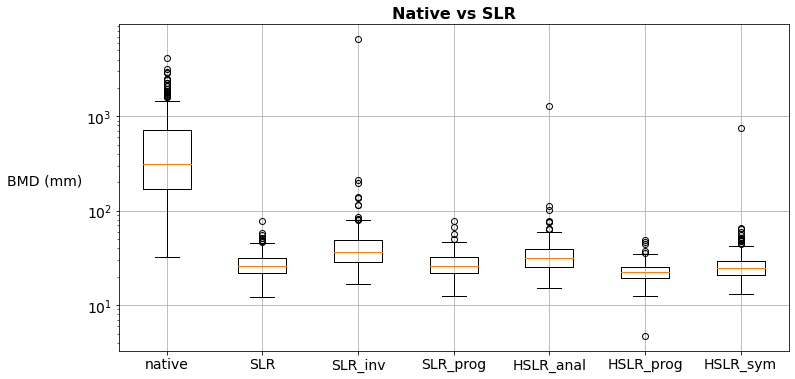

In [11]:
data = [d_0, d_slr, d_slr_inv, d_slr_prog, d_hslr_anal, d_hslr_prog, d_hslr_sym]
labels = ['native', 'SLR', 'SLR_inv', 'SLR_prog', 'HSLR_anal', 'HSLR_prog', 'HSLR_sym']

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.boxplot(data)
# ax.violinplot(data_with_raw, showmedians=True)
ax.set_title('Native vs SLR',fontsize=16, fontweight='bold')
ax.set_ylabel('BMD (mm)', rotation='horizontal', ha='right', fontsize=14)
ax.set_yscale('log')
ax.grid()
ax.set_xticks(np.arange(1, len(labels) + 1))
_ = ax.set_xticklabels(labels)
ax.tick_params(axis='both',which='major',labelsize=14)

In [12]:
print(labels)
print([np.round(np.mean(d), 1) for d in data])
print([np.round(np.median(d), 1) for d in data])
print([np.round(np.std(d), 1) for d in data])
print([np.round(np.percentile(d, 25), 1) for d in data])
print([np.round(np.percentile(d, 75), 1) for d in data])

['native', 'SLR', 'SLR_inv', 'SLR_prog', 'HSLR_anal', 'HSLR_prog', 'HSLR_sym']
[549.6, 27.5, 63.7, 27.4, 37.7, 22.8, 28.6]
[315.0, 26.0, 36.6, 25.9, 31.3, 22.3, 24.7]
[600.1, 8.2, 375.6, 8.4, 74.0, 5.4, 42.2]
[168.0, 21.8, 29.0, 21.7, 25.6, 19.3, 20.8]
[717.5, 31.7, 49.2, 32.1, 38.9, 25.5, 29.6]


#### Differences between methods (excluding native space)

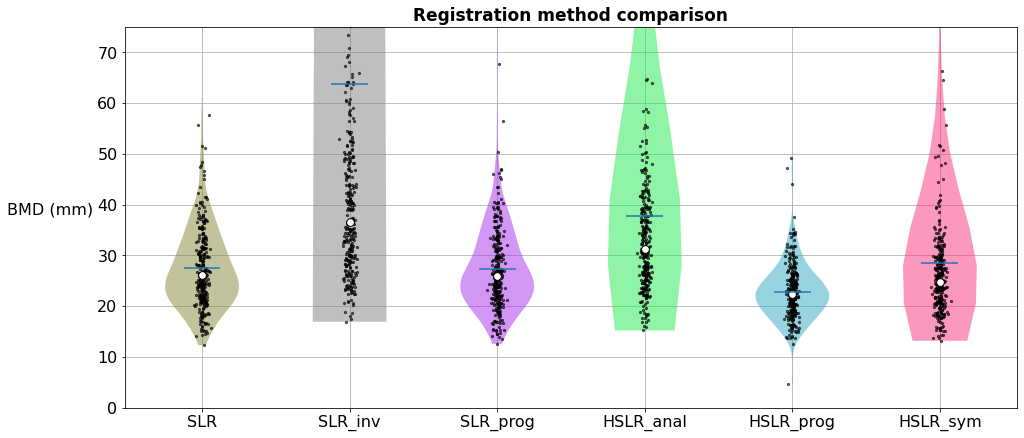

In [27]:
colors = [[0.53, 0.53, 0.24], [0.5, 0.5, 0.5], [0.65, 0.19, 0.92], [
    0.13, 0.92, 0.3], [0.19, 0.67, 0.76], [0.98, 0.19, 0.49]]

fig, ax = plt.subplots()

fig.set_size_inches(16, 7)

y_min = 0
y_max = 75

vp = ax.violinplot(data[1:], showmeans=True, showmedians=False, showextrema=False)
ax.grid()
ax.set_axisbelow(True)
ax.set_title('Registration method comparison', fontsize=17, fontweight='bold')
ax.set_ylabel('BMD (mm)', rotation='horizontal', ha='right', fontsize=16)
ax.set_xticks(np.arange(1, len(labels)))
ax.set_xticklabels(labels[1:])
ax.tick_params(labelsize=16)
ax.set_ylim(y_min, y_max)
s = 0.02
for i, pc in enumerate(vp['bodies']):
    pc.set_facecolor(colors[i])
    # pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    x = (i+1) + s*np.random.randn(N)
    ax.scatter(x, data[i+1], 5, color=[0, 0, 0], alpha=0.6)
    ax.scatter((i+1), np.median(data[i+1]), 60,
               color=[1, 1, 1], alpha=1, edgecolors=[0, 0, 0])

Most of the approaches did not improve SLR and introduced outliers (might be interesting to check where do they come from).

The approach of running HSLR progressively showed the best results with even a slight improvement over SLR.